In [1]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import numpy as np
from itertools import chain
import patsy
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.display import display
pd.set_option('display.max_rows', 1000)

In [3]:
from scipy.stats import norm

In [4]:
import matplotlib.patches as mpatches

In [5]:
all_h2_rg = pd.read_table("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/FINAL/all_h2_rg.tsv",index_col="factor")

In [6]:
all_h2_rg["h2_lower"] = all_h2_rg["h2_full"]-all_h2_rg["h2_se_full"]
all_h2_rg["h2_upper"] = all_h2_rg["h2_full"]+all_h2_rg["h2_se_full"]
all_h2_rg["h2"] = all_h2_rg["h2_full"]

In [7]:
orderedfac = ["f1","f2","f3","f4","f5","f6","f7","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25","f26","f27","f28","f29","f30","f31","f32","f33","f34","f35","f36"]

In [8]:
all_h2_rg = all_h2_rg.loc[orderedfac]

In [9]:
all_h2_rg[["h2_full","h2_se_full"]]

,h2_full,h2_se_full
factor,,
f1,0.0330,0.0073
f2,0.0930,0.0083
f3,0.0764,0.0083
f4,0.0132,0.0027
f5,0.1124,0.0110
f6,0.0813,0.0042
f7,0.2445,0.0094
f9,0.1197,0.0091
f10,0.2113,0.0097


In [10]:
cfafactors = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/TRAINING/redux10point2/for_jupyter/loadings.txt",sep="\t")

In [11]:
factordict = cfafactors.groupby('factor')["item "].apply(lambda x: x.tolist()).to_dict()

In [12]:
nealeh2 = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/ukb31063_h2_all.02Oct2019.tsv.gz", sep="\t")

/local/scratch/42452845.1.interactive/ipykernel_10177/135564914.py:1: DtypeWarning: Columns (2,792) have mixed types. Specify dtype option on import or set low_memory=False.
  nealeh2 = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/ukb31063_h2_all.02Oct2019.tsv.gz", sep="\t")


In [13]:
nealeh2_bothsexes = nealeh2[nealeh2.sex=="both_sexes"]
nealeh2_bothsexes_dropirnt = nealeh2_bothsexes[~(nealeh2_bothsexes.variable_type=="continuous_irnt")]
nealeh2_bothsexes_dropirnt.loc[nealeh2_bothsexes_dropirnt.phenotype.apply(lambda x: "_raw" in x),"phenotype"] = nealeh2_bothsexes_dropirnt[nealeh2_bothsexes_dropirnt.phenotype.apply(lambda x: "_raw" in x)].phenotype.apply(lambda x: x.split("_")[0])
nealeh2_bothsexes_dropirnt.loc[nealeh2_bothsexes_dropirnt.source=="icd10","phenotype"] = nealeh2_bothsexes_dropirnt.loc[nealeh2_bothsexes_dropirnt.source=="icd10"].phenotype.apply(lambda x: "41202_"+x)

In [14]:
cfaitems = cfafactors["item "].values
cfaitems = [x[1:] for x in cfaitems]

In [15]:
nealeh2_items = nealeh2_bothsexes_dropirnt[nealeh2_bothsexes_dropirnt.phenotype.isin(cfaitems)]

In [16]:
nealeh2_items_only = nealeh2_items[["phenotype","h2_observed","h2_observed_se","Neff"]].set_index("phenotype")

In [17]:
cfafactors["abs_loading"] = abs(cfafactors["loading"])
cfafactors = cfafactors.sort_values(["factor","abs_loading"],ascending=[True,False])
cfafactors["orderednum"] = cfafactors.groupby('factor').cumcount().add(1)
cfafactors["item"] = cfafactors.apply(lambda x: x["item "][1:],axis=1)
cfafactors = cfafactors.drop("item ",axis=1)
cfafactors = cfafactors[cfafactors.orderednum<=10]

In [18]:
import math

In [19]:
facs = sorted(factordict.keys(),key=lambda e: int(e[1:]))

In [20]:
from matplotlib.lines import Line2D


In [21]:
# fig, axes = plt.subplots(5, 7, sharex=False, sharey=False, figsize=(20,15))
# for i,factor in enumerate(facs):
#     cfafac = cfafactors.loc[cfafactors["factor"]==factor]
#     cfafac["h2"] = cfafac["item"].apply(lambda x: nealeh2_items_only.loc[x,"h2_observed"])
#     cfafac["h2_se"] = cfafac["item"].apply(lambda x: nealeh2_items_only.loc[x,"h2_observed_se"])
#     cfafac["h2_lower"] = cfafac.h2-cfafac.h2_se
#     cfafac["h2_upper"] = cfafac.h2+cfafac.h2_se
#     toplot = cfafac[["item","h2","h2_lower","h2_upper"]]
#     toplotfactor = pd.DataFrame(columns=["item ","h2","h2_lower","h2_upper"])
#     toplotfactor = toplotfactor.append({"item" : "factor", "h2" : all_h2_rg.loc[factor,"h2"], "h2_lower" : all_h2_rg.loc[factor,"h2_lower"], "h2_upper" : all_h2_rg.loc[factor,"h2_upper"]},ignore_index=True)
#     toplot = pd.concat([toplotfactor,toplot]).reset_index(drop=True).set_index("item")
#     toplot["y"] = list(range(1,toplot.shape[0]+1))[::-1]
#     toplot["color"] = "orange"
#     toplot.loc["factor","color"]="blue"
#    #plt.figure(figsize=(8, 8))
#     h = axes[math.floor(i / 7),i % 7].scatter(x=toplot.h2,y=toplot.y,color=toplot.color)
#    #plt.yticks(range(1,len(toplot.h2)+1), toplot.index[::-1])
#     axes[math.floor(i / 7),i % 7].set_title(factor.upper())
#     for item in toplot.index:
#         lower = toplot.loc[item,"h2_lower"]
#         upper = toplot.loc[item,"h2_upper"]
#         yval = toplot.loc[item,"y"]
#         axes[math.floor(i / 7),i % 7].plot([lower,upper],[yval,yval],color=toplot.loc[item,"color"])
#     axes[math.floor(i / 7),i % 7].get_yaxis().set_visible(False)
# legend_elements = [Line2D([0], [0], marker='o',color='blue', label='factor'),
#                    Line2D([0], [0], marker='o', color='orange', label='item')]
# fig.legend(handles=legend_elements,bbox_to_anchor=(0.55,-0.01),ncol=2)
# #fig.legend(h,["factor","item"],bbox_to_anchor=(0.65,-0.01),ncol=2)
# fig.tight_layout()
# plt.savefig("/stanley/robinson/ccarey/factor_paper_revision/figures_RKWchecklist/ED_Figure9_journal_RKW.jpg",bbox_inches="tight")
# plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


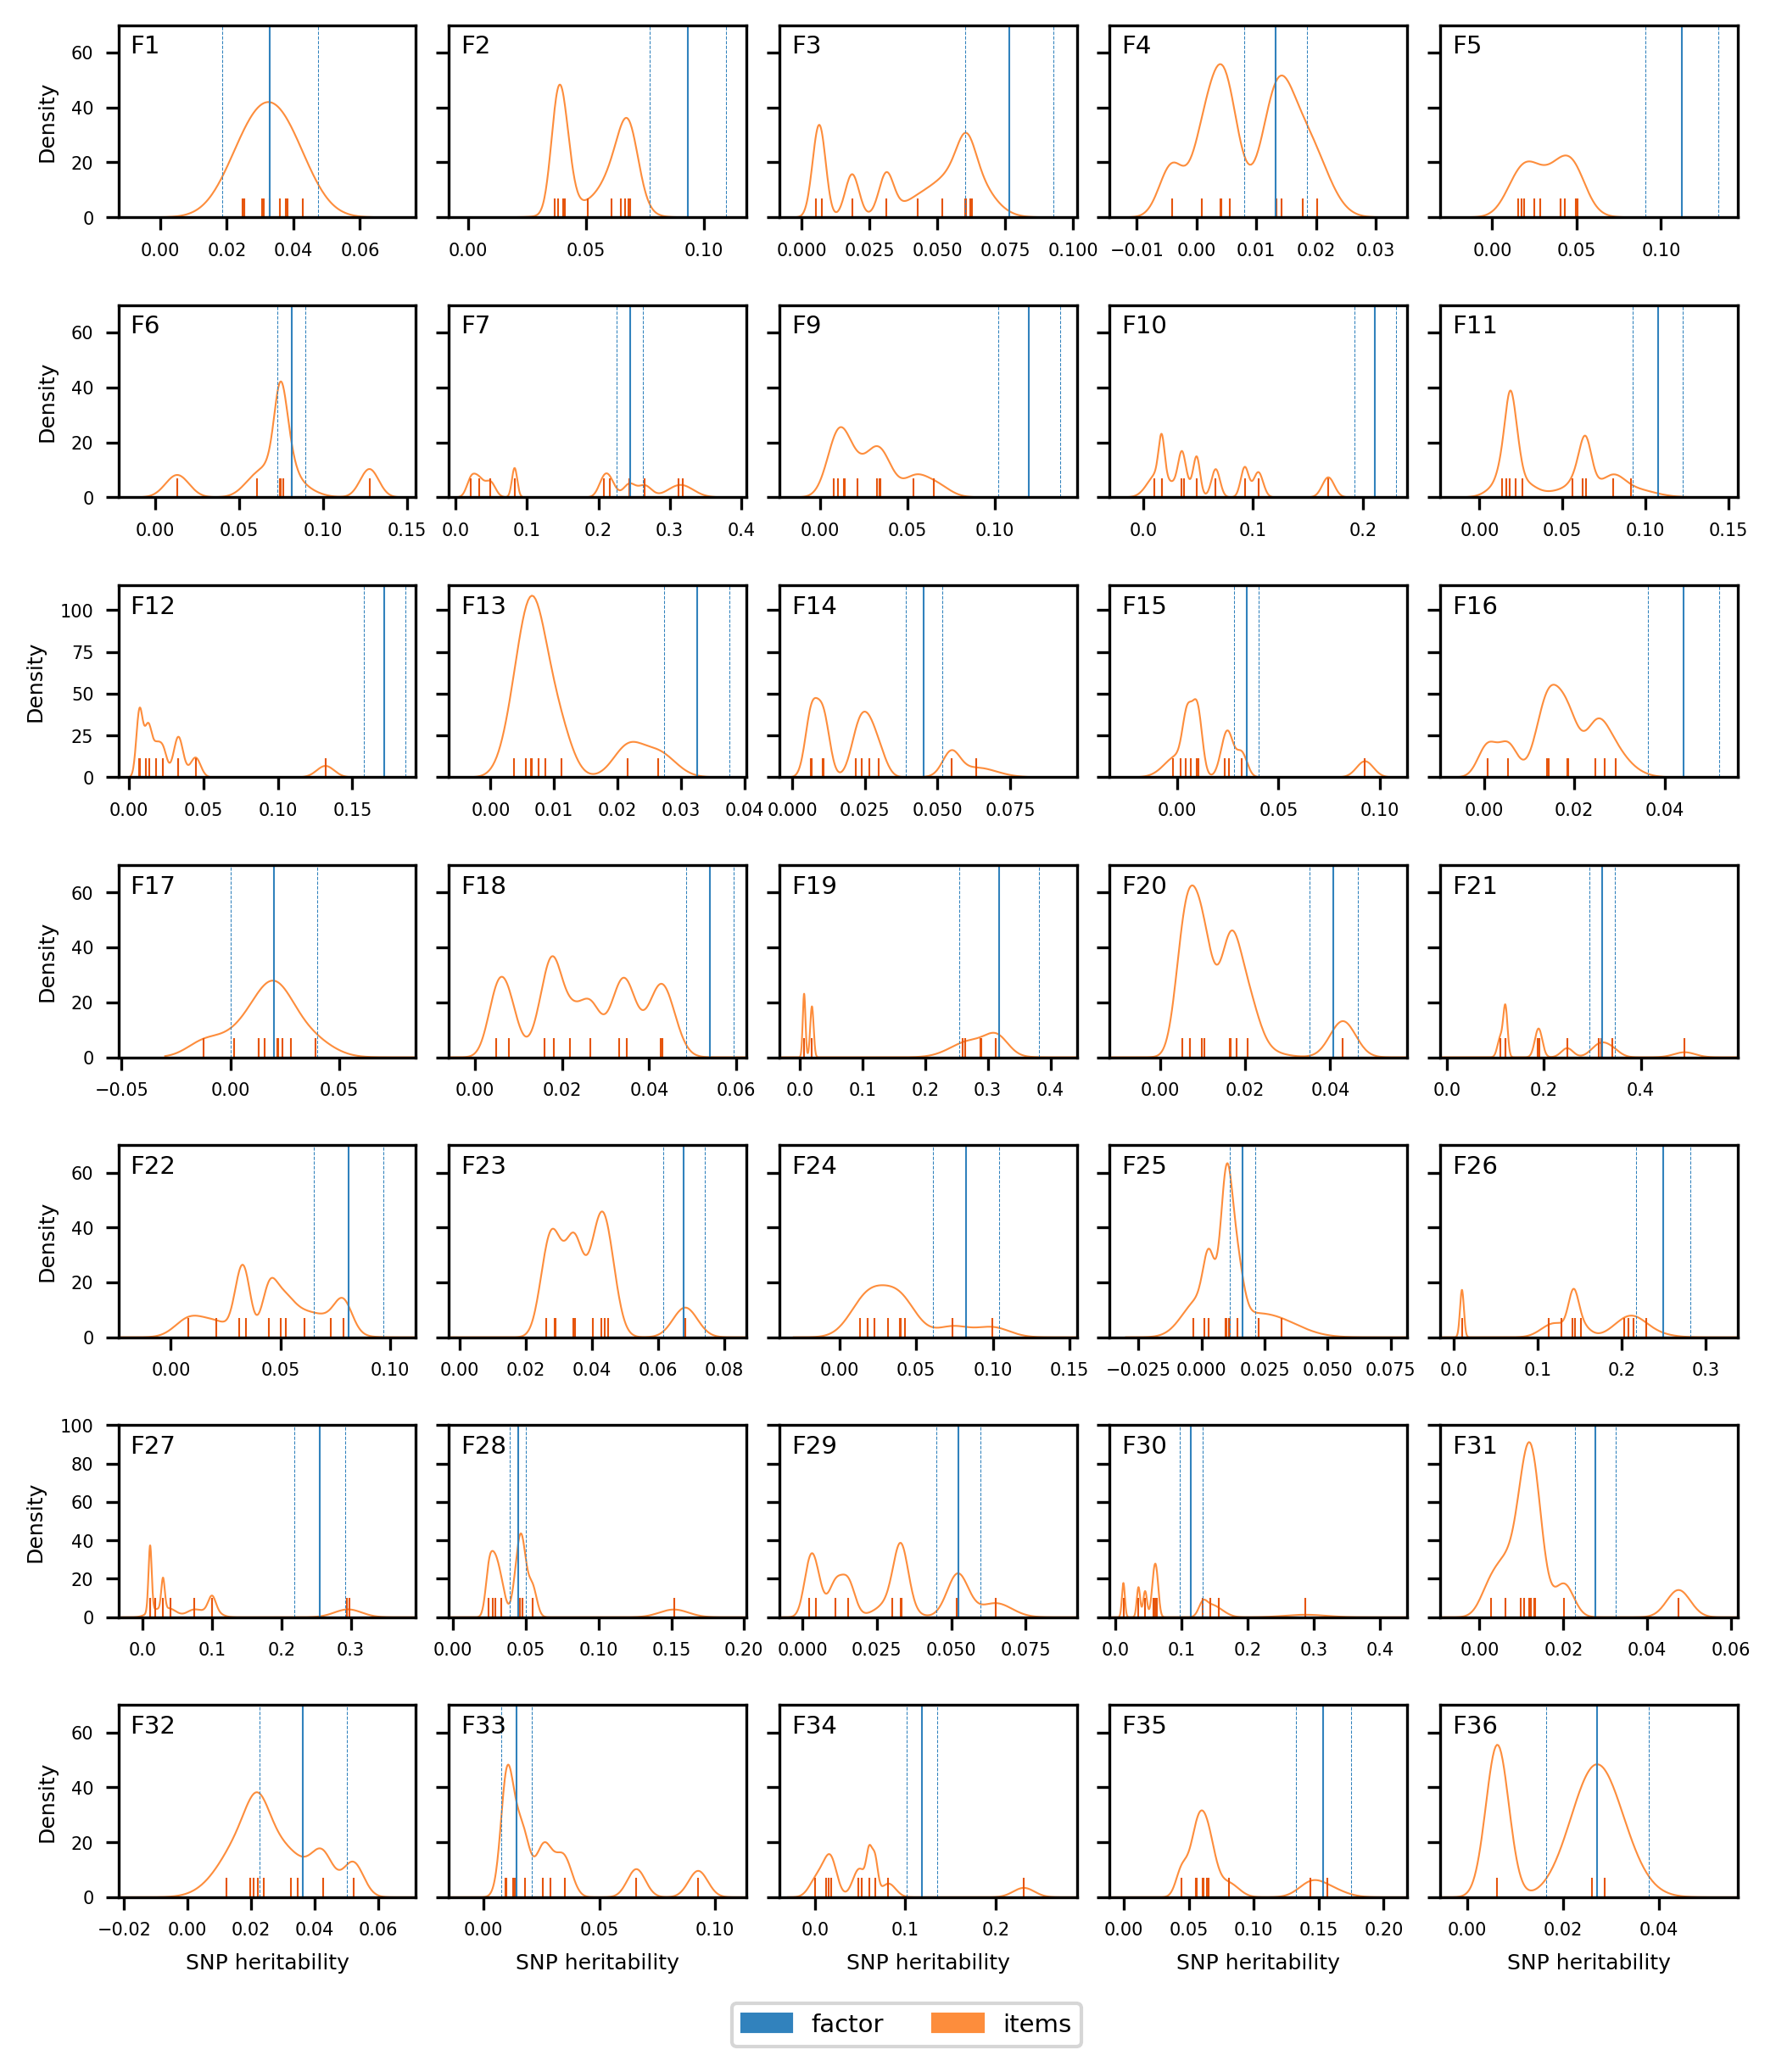

In [22]:
fig, axes = plt.subplots(8, 5, sharex=False, sharey='row', figsize=(7.086,8.267), gridspec_kw={'height_ratios':[1,1,1,1,1,1,1,0.35]},dpi=300)
ncol=5

nq = 2500
qq = np.linspace(start=-.03, stop=.7, num=nq)

blue = sns.color_palette('tab20c')[0]
orange = sns.color_palette('tab20c')[5]
darkorange = sns.color_palette('tab20c')[4]

for i,factor in enumerate(facs):
    
    cfafac = cfafactors.loc[cfafactors["factor"]==factor]
    cfafac["h2"] = cfafac["item"].apply(lambda x: nealeh2_items_only.loc[x,"h2_observed"])
    cfafac["h2_se"] = cfafac["item"].apply(lambda x: nealeh2_items_only.loc[x,"h2_observed_se"])

    dd = [sum(norm.pdf(x, loc=cfafac.h2, scale=cfafac.h2_se)/(cfafac.shape[0])) for x in qq]
    axes[math.floor(i / ncol),i % ncol].plot(qq, dd, color=orange,linewidth=0.5)
       
    # sns.kdeplot(ax=axes[math.floor(i / ncol),i % ncol], data=cfafac, bw_adjust=0.5, x="h2", color="orange")
    sns.rugplot(ax=axes[math.floor(i / ncol),i % ncol], data=cfafac, x="h2", color=darkorange, height=.1, linewidth=0.5)
    # sns.histplot(ax=axes[math.floor(i / ncol),i % ncol], data=cfafac, x="h2", stat="density", color="orange")
    
    axes[math.floor(i / ncol),i % ncol].axvline(x=all_h2_rg.loc[factor,"h2_full"], color=blue, linewidth=0.5)
    axes[math.floor(i / ncol),i % ncol].axvline(x=all_h2_rg.loc[factor,"h2_full"]+1.96*all_h2_rg.loc[factor,"h2_se_full"], color=blue, linestyle='--', linewidth=0.25)
    axes[math.floor(i / ncol),i % ncol].axvline(x=all_h2_rg.loc[factor,"h2_full"]-1.96*all_h2_rg.loc[factor,"h2_se_full"], color=blue, linestyle='--', linewidth=0.25)

    
    # axes[math.floor(i / ncol),i % ncol].axvline(x=0, color="black", linewidth=0.25, linestyle=':')


    if math.floor(i / ncol) == 2:
        axes[math.floor(i / ncol),i % ncol].set(ylim=(0,115))
    elif math.floor(i / ncol) == 5:
        axes[math.floor(i / ncol),i % ncol].set(ylim=(0,100))
    else:
        axes[math.floor(i / ncol),i % ncol].set(ylim=(0,70))
    
    xupper = max(cfafac.h2+5*cfafac.h2_se)
    xupper = max(xupper, all_h2_rg.loc[factor,"h2_full"]+3*all_h2_rg.loc[factor,"h2_se_full"])
    xlower = min(cfafac.h2-5*cfafac.h2_se)
    xlower = min(xlower, all_h2_rg.loc[factor,"h2_full"]-3*all_h2_rg.loc[factor,"h2_se_full"])  
    xlower = min(xlower, -1*all_h2_rg.loc[factor,"h2_se_full"])      
    # xlower = min(xlower, 0)
    if i == 31:
        xlower = -.015
    axes[math.floor(i / ncol),i % ncol].set(xlim=(xlower,xupper)) 

    
    axes[math.floor(i / ncol),i % ncol].tick_params(axis='both', which='major', labelsize=5)
    
    # axes[math.floor(i / ncol),i % ncol].set_title(factor, fontsize=6)
    axes[math.floor(i / ncol),i % ncol].text(0.04, 0.95, factor.upper(), size=7, horizontalalignment='left', verticalalignment='top', transform=axes[math.floor(i / ncol),i % ncol].transAxes)

    
    if math.floor(i / ncol) == 6:
        axes[math.floor(i / ncol),i % ncol].set_xlabel("SNP heritability", fontsize=6)
    else:
        axes[math.floor(i / ncol),i % ncol].set_xlabel("", fontsize=0)
        
    if i % ncol == 0:
        axes[math.floor(i / ncol),i % ncol].set_ylabel("Density", fontsize=6)

for j in range(0,5):
    axes[7,j].set_visible(False)        

blue_patch = mpatches.Patch(color=blue, label='factor')
orange_patch = mpatches.Patch(color=orange, label='items')
fig.legend(handles=[blue_patch, orange_patch], ncol=2, bbox_to_anchor=(0.51, 0.015), loc='lower center', fontsize=7)


fig.tight_layout(w_pad=0.005, h_pad=0.33)
plt.savefig("/stanley/robinson/ccarey/factor_paper_revision/edfigs_CEC/EDFig9.eps") #,bbox_inches="tight")